# Introduction

Consider a signal $s(t)$ periodic with period $T$.

Fourier analysis says that $s(t)$ can be expressed as a linear combination of basis sinusoids with periods $T/n$. These sinusoids are also periodic in $T$.

$$s(t) = \sum_{n=-\infty}^\infty A_n \exp\left(2\pi j \frac{n t}{T}\right)$$

In the space of all possible signals with period $T$, these basis sinusoids are orthogonal. In other words, the inner product between basis sinusoids are 0 if they are different and 1 if they are the same.

$$\frac{1}{T}\int_0^T \left[\exp\left(2\pi j \frac{n t}{T}\right)\right] \left[\exp\left(-2\pi j \frac{m t}{T}\right)\right] dt  = \frac{1}{T}\int_0^T \exp\left(2\pi j \frac{(n-m)t}{T}\right) = \delta_{nm} $$ 

This means that it is possible to extract the component of basis component through the humble inner product. (This is the principle behind the fourier analysis.)

$$A_n = \int_0^T s(t)\exp\left(-2\pi j \frac{nt}{T}\right) dt $$

Fourier Transform generalizes this idea by extending the period $T$ to $\infty$. As the period of the signal tends to infinity, the basis sinusoids becomes more closely separated in frequency space until we can consider every point on the continuous frequency space to be a basis sinusoid.

Nyquist theorem addresses the issue of what happens when we only have a regularly sampled representation of a signal $s[t]$ instead of a continuous signal $s(t)$. If we think of sampling as multiplying the continuous signal by a dirac delta train, then in frequency space the $s[t]$ is simply the convolution of the FT of the dirac delta train with the FT of $s(t)$. The FT of a dirac delta train is another dirac delta train. Looking at this convolution in frequency space, we realised $s(t)$ needs to be bandlimited in order for us to be able to recover $s(t)$ from $s[t]$. In other words, sampling introduces a limit to the highest frequency basis that we can represent. 

There is another issue of what happens when we have a finite length of sampled signal. As necessary for fourier analysis, we assume that the signal is periodic. That is, the signal repeats after the length of recording. The shorter the signal  duration, the larger the lowest frequency basis allowed. Since sinusoidal basis are multiples of the lowest frequency basis, the spacing between basis function is also larger. In other words, the length of the signal recording determines the frequency resolution of the recorded signal length.

# Problem Statement

What happens if a signal recorded by discrete sampling is not one of the basis frequencies? In other words, we broke the fundamental fourier assumptions of periodicity and the true frequency lies in between two basis frequencies. This is a realistic scenario because when we are recording a signal to estimate its frequency, we are unlikely to record a signal length that is a multiple of the signal's true period

This notebook attempts to show:
1. There is energy spillage from the non-basis sinusoid into the basis sinusoid
2. This spillage can be controlled by window functions
3. Capon's method is an alternative to fourier based spectral estimation
4. MUSIC is an alternative to fourier based spectral estimation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as spsg

Consider this experiment. We will observe an tone of arbitrary frequency for 1 second and will sample it insufficiently to resolve the frequency of the tone

In [4]:
valid = False
Fs = 8
DURATION = 1
while not valid:
    test_f = 1/np.random.rand()
    if test_f <Fs/2:
        valid=True
print("frequency of test tone", test_f)

frequency of test tone 1.2834128976146266


Complex experiment

In [40]:
t_samples = np.linspace(0,DURATION, Fs*DURATION, endpoint=False)
y_samples = np.exp(2*np.pi*1j*test_f*t_samples)

In [41]:
t_highres = np.linspace(0,DURATION,Fs*100*DURATION)
y_highres = np.exp(2*np.pi*1j*test_f*t_highres)

In [42]:
t_longres = np.linspace(0,100*DURATION,100*DURATION*Fs )
y_longres = np.exp(2*np.pi*1j*test_f*t_longres)

In [43]:
t_resamples = np.linspace(0,DURATION, 100*Fs*DURATION, endpoint=False)
y_resamples = spsg.resample(y_samples, 100*Fs*DURATION)

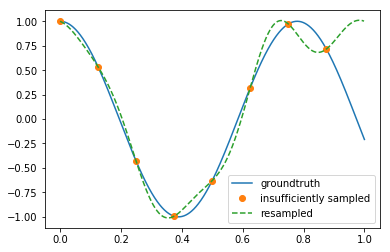

In [49]:
plt.plot(t_highres, np.real(y_highres), label="groundtruth")
plt.plot(t_samples, np.real(y_samples), linestyle='', marker="o", label="insufficiently sampled")
plt.plot(t_resamples, np.real(y_resamples), linestyle='--', label="resampled")
plt.legend()
plt.show()

In [44]:
fvec_highres = np.linspace(-Fs*100/2,Fs*100/2,len(y_highres), endpoint=False)
fvec_samples = np.linspace(-Fs/2,Fs/2,len(y_samples), endpoint=False)
fvec_resamples = np.linspace(-Fs*100/2,Fs*100/2,len(y_resamples), endpoint=False)
fvec_longres = np.linspace(-Fs/2,Fs/2,len(y_longres), endpoint=False)

In [45]:
fft_highres = np.fft.fftshift(np.fft.fft(y_highres)) / len(y_highres)
fft_samples = np.fft.fftshift(np.fft.fft(y_samples)) / len(y_samples)
fft_resamples = np.fft.fftshift(np.fft.fft(y_resamples)) / len(y_resamples)
fft_longres = np.fft.fftshift(np.fft.fft(y_longres)) / len(y_longres)

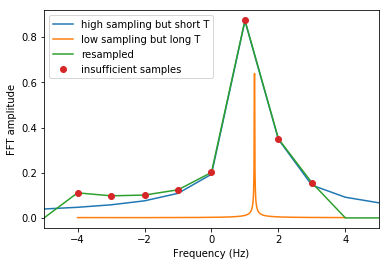

In [50]:
plt.plot(fvec_highres, np.abs(fft_highres), label="high sampling but short T")
plt.plot(fvec_longres, np.abs(fft_longres), label="low sampling but long T")
plt.plot(fvec_resamples, np.abs(fft_resamples), label="resampled")
plt.plot(fvec_samples, np.abs(fft_samples), linestyle='', marker="o", label="insufficient samples")
plt.xlim([-Fs/2 - 1,Fs/2+1])
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("FFT amplitude")
plt.show()

In [92]:
# capon method
capon_fvec = np.linspace(-Fs/2 - 1,Fs/2+1,1000, endpoint=False)
a = np.einsum( 'i,j->ij', capon_fvec, t_samples)
a = np.exp(-2*np.pi*1j*a)

R = np.einsum('i,j->ij', y_samples, y_samples.conj())
inv_R_smallDL = np.linalg.inv(R+0.001*np.eye(len(R))) 
inv_power_smallDL = np.diag(np.matmul(a,np.matmul(inv_R_smallDL, a.conj().T)))

inv_R_largeDL = np.linalg.inv(R+0.1*np.eye(len(R))) 
inv_power_largeDL = np.diag(np.matmul(a,np.matmul(inv_R_largeDL, a.conj().T)))

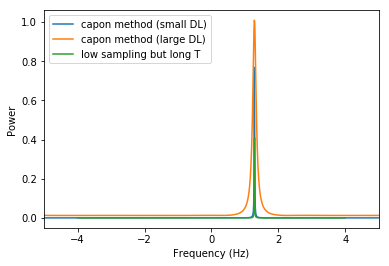

In [93]:
plt.plot(capon_fvec,np.abs(1/inv_power_smallDL), label="capon method (small DL)")
plt.plot(capon_fvec,np.abs(1/inv_power_largeDL), label="capon method (large DL)")
plt.plot(fvec_longres, np.abs(fft_longres)**2, label="low sampling but long T")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.xlim([-Fs/2 - 1,Fs/2+1])
plt.show()